In [33]:
import os
import sys

sys.path.append('../')

import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from torch.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from kwave.ktransducer import kWaveGrid
from models.das import DelayAndSum
from utils.dataio import load_mat
from utils.simulations import get_water_sos
from utils.reconstruction import get_gaussian_window

from utils.visualization import *

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

plt.rcParams.update({'font.weight': 'semibold'})

DATA_PATH = '../data/'

In [34]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_sos(T)   # Background SoS [m/s].
N_transducer = 512
f = 40e6              # Frequency [Hz].
n_delays = 16
delays = torch.linspace(-8e-4, 8e-4, n_delays).view(-1,1,1) + 215 * v0 / f

In [35]:
eir = torch.from_numpy(load_mat(os.path.join(DATA_PATH, 'EIR_TUNGSTEN.mat')))
print(eir.shape)

torch.Size([1, 2000])


In [36]:
delta = torch.zeros(1, 2000)
delta[0, torch.argmax(eir[0, :])] = 1

In [37]:
delta = delta[:,1:] - delta[:,:-1]

In [38]:
eir_fft = fft(eir[0]).abs()

In [39]:
N = 512
dx = 4e-5
kgrid = kWaveGrid([N, N], [dx, dx])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec

In [40]:
fwhm = 1.5e-3
sigma = fwhm / 4e-5 / math.sqrt(2*math.log(2))
gaussian_window = torch.from_numpy(get_gaussian_window(sigma, N)).unsqueeze(0)

In [41]:
das = DelayAndSum(R_ring=0.05, N_transducer=N_transducer, T_sample=1/f, x_vec=x_vec, y_vec=y_vec, mode='zero').cuda()
das.eval()

DelayAndSum()

In [42]:
img_stack_eir = []
with torch.no_grad():
    for d_delay in tqdm(delays, desc='DAS'):
        recon = das(sinogram=eir.repeat(N_transducer, 1).cuda(), 
                    v0=torch.tensor(v0).cuda(),
                    d_delay=d_delay.cuda(),
                    ring_error=torch.zeros(1).cuda())
        img_stack_eir.append(recon)
img_stack_eir = torch.stack(img_stack_eir, dim=0).detach().cpu() #* gaussian_window

DAS: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]


In [43]:
img_stack_delta = []
with torch.no_grad():
    for d_delay in tqdm(delays, desc='DAS'):
        recon = das(sinogram=delta.repeat(N_transducer, 1).cuda(), 
                    v0=torch.tensor(v0).cuda(),
                    d_delay=d_delay.cuda(),
                    ring_error=torch.zeros(1).cuda())
        img_stack_delta.append(recon)
img_stack_delta = torch.stack(img_stack_delta, dim=0).detach().cpu() # * gaussian_window

DAS: 100%|██████████| 16/16 [00:01<00:00, 13.22it/s]


In [44]:
mtf_stack_eir = ifftshift(fft2(img_stack_eir, dim=(-2,-1))).abs()
mtf_stack_delta = ifftshift(fft2(img_stack_delta, dim=(-2,-1))).abs()
mtf_stack = mtf_stack_eir / mtf_stack_delta

In [45]:
# img_stack_eir = torch.zeros_like(img_stack_eir)
# img_stack_eir[:, N//2, N//2] = 1
# mtf_stack_eir = ifftshift(fft2(img_stack_eir, dim=(-2,-1))).abs()

In [46]:
idx = 7

In [47]:
mtf_stack_delta.min(), mtf_stack_delta.max()

(tensor(0.0007), tensor(4.7923))

In [48]:
slice = int(N*0.01)

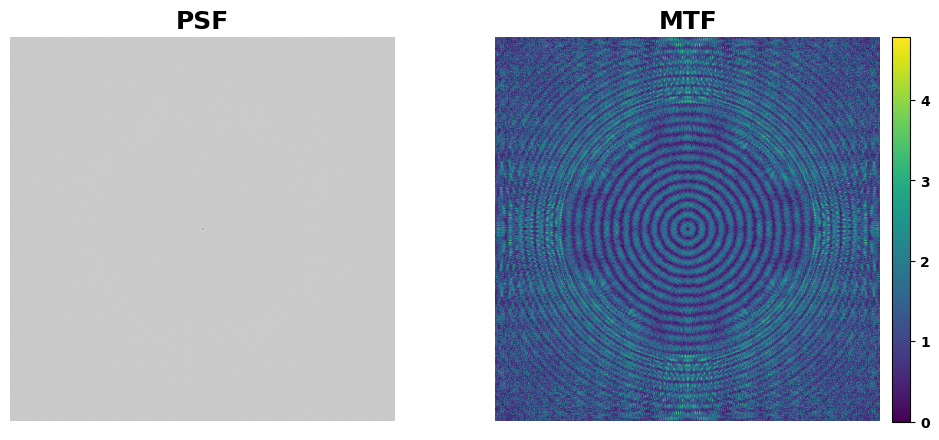

In [49]:
fig = plt.figure(figsize=(12, 5))
norm_img = Normalize(vmin=img_stack_delta.min(), vmax=img_stack_delta.max())
norm_kspace = Normalize(vmin=0, vmax=mtf_stack_delta.max())
gs = plt.GridSpec(2, 4)

ax = plt.subplot(gs[0:2,0:2])
plt.imshow(img_stack_delta[idx,slice:-slice,slice:-slice], cmap='gray', norm=norm_img)
plt.title('PSF', fontsize=18, fontweight='bold')
plt.axis('off')


ax = plt.subplot(gs[0:2,2:4])
plt.imshow(mtf_stack_delta[idx,slice:-slice,slice:-slice].abs(), norm=norm_kspace)
plt.title('MTF', fontsize=18, fontweight='bold')
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.015, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm_kspace)

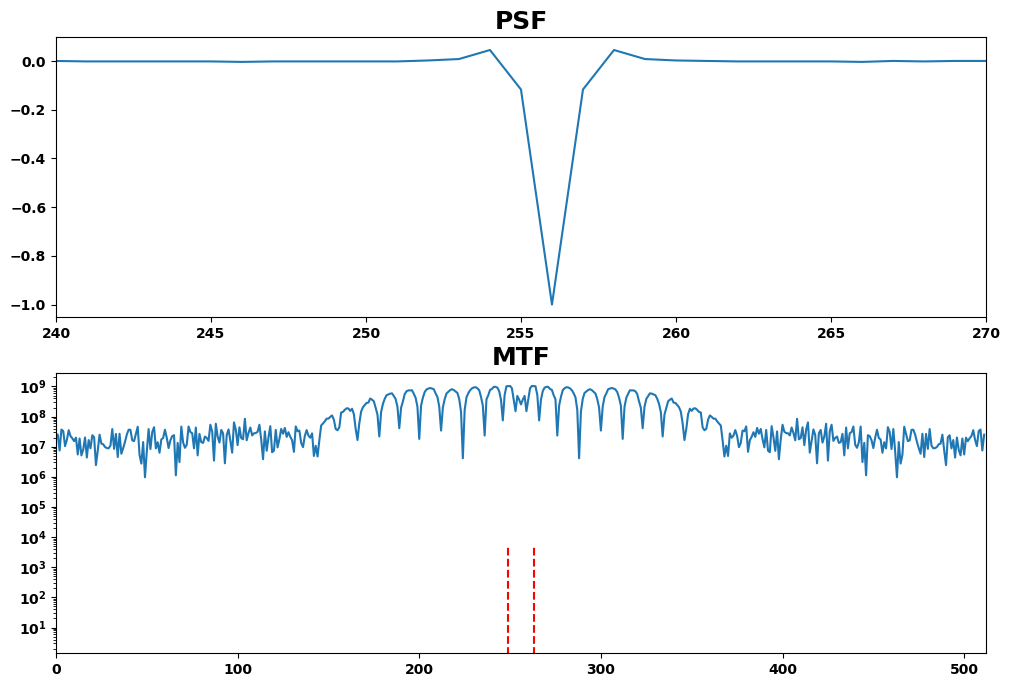

In [50]:
fig = plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(img_stack_delta[idx,N//2,:])
plt.xlim(240,270)
# plt.yscale('log')
plt.title('PSF', fontsize=18, fontweight='bold')

plt.subplot(212)
plt.plot(mtf_stack_eir[idx,N//2,:])
plt.xlim(0, N)
plt.yscale('log')
plt.title('MTF', fontsize=18, fontweight='bold')
plt.vlines(249, color='red', linestyle='--', ymin=0.1, ymax=5e3)
plt.vlines(263, color='red', linestyle='--', ymin=0.1, ymax=5e3)

### Load weighting comparison results

In [51]:
n_delays = 16
hls, hfs = 0, 256
lr_nf = 5e-3

In [52]:
params = f'{n_delays}delays_{hls}lyrs_{hfs}fts_10epochs_bs=64_lr={lr_nf:.1e}'
IP_nf_no_k = load_mat(os.path.join('../results_rebuttals/numerical_full_apact/', 'NF-APACT', params, 'IP_rec.mat'))
IP_nf_k = load_mat(os.path.join('../results_new/numerical_full_apact/', 'NF-APACT', params, 'IP_rec.mat'))
IP_nf_k2 = load_mat(os.path.join('../results_rebuttals1/numerical_full_apact/', 'NF-APACT', params, 'IP_rec.mat'))

IP_gt = load_mat(os.path.join(DATA_PATH, 'IP_APACT_1.mat'))

In [53]:
[IP_nf_no_k, IP_nf_k, IP_nf_k2] = [standardize(img) for img in [IP_nf_no_k, IP_nf_k, IP_nf_k2]]
data_range_ip = 15.5

### Create figure

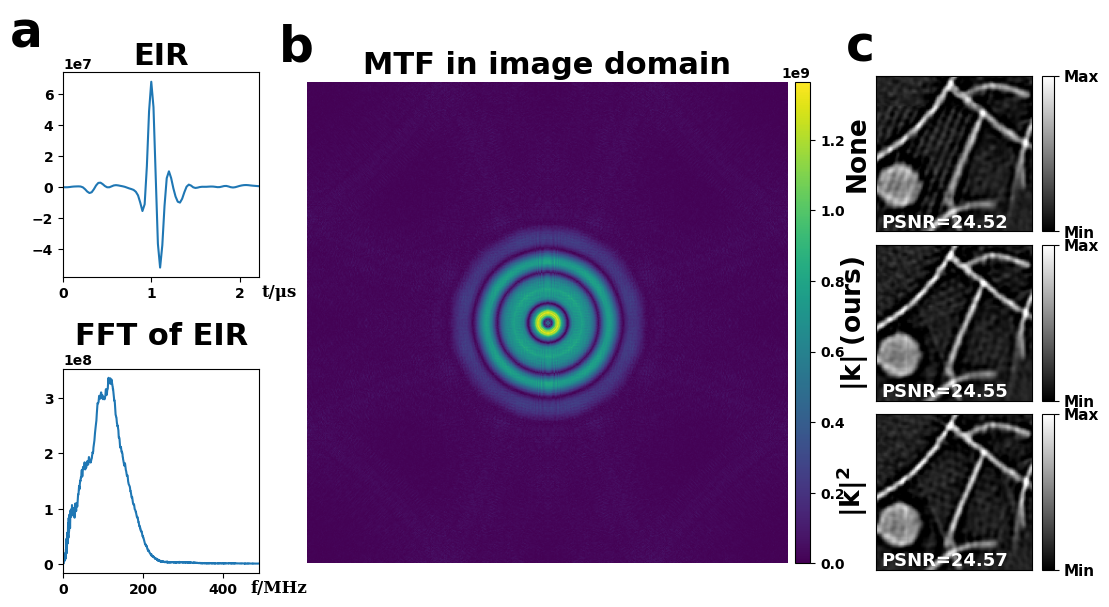

In [67]:
fig = plt.figure(figsize=(12.5, 6.5))
norm_img = Normalize(vmax=5, vmin=-1)
# norm_kspace = LogNorm(vmin=mtf_stack_eir.min(), vmax=mtf_stack_eir.max())
norm_kspace = Normalize(vmin=0, vmax=mtf_stack_eir.max())
gs = plt.GridSpec(12,24)

# EIR.
ax = plt.subplot(gs[0:5,0:5])
plt.plot(np.arange(90)/40, eir[0,1080:1170])
plt.xlim(0, 89/40)
# plt.xticks([])
plt.title('EIR', fontsize=22, fontweight='bold')
plt.xlabel('t/μs', fontsize=12, fontweight='bold', fontfamily='DejaVu Serif', x=1.1, labelpad=-12)
ax.text(s='a', x=-0.6, y=9e7, fontsize=35, fontweight='semibold', color='black')

ax = plt.subplot(gs[7:12,0:5])
plt.plot(np.arange(2000)*2*math.pi/N*f/1e6, eir_fft)
plt.xlim(0, 1000*2*math.pi/N*f/1e6)
# plt.xticks([])
plt.title('FFT of EIR', fontsize=22, fontweight='bold')
plt.xlabel('f/MHz', fontsize=12, fontweight='bold', fontfamily='DejaVu Serif', x=1.1, labelpad=-12)

# MTF.
ax = plt.subplot(gs[0:12,6:18])
plt.imshow(mtf_stack_eir[idx].abs(), norm=norm_kspace)
plt.title('MTF in image domain', fontsize=22, fontweight='bold')
plt.axis('off')
ax.text(s='b', x=-30, y=-23, fontsize=35, fontweight='semibold', color='black')
cax = fig.add_axes([ax.get_position().x1+0.006, ax.get_position().y0, 0.012, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm_kspace)

# Weighting comparison.
x, y = 260, 380
for idx, (img, title) in enumerate(zip([IP_nf_no_k, IP_nf_k, IP_nf_k2],
                                       ['None', r'$\vert \mathbf{k} \vert$ (ours)', r'$\vert \mathbf{k} \vert ^2$'])):
    ax = plt.subplot(gs[idx*4:(idx+1)*4, 20:24])
    plt.imshow(img[x:x+100,y:y+100], cmap='gray', norm=norm_img)
    plt.ylabel(title, fontsize=19, fontweight='bold')
    ax.text(s='PSNR={:.2f}'.format(psnr(IP_gt, img, data_range=data_range_ip)), x=3, y=97, fontsize=13, fontweight='semibold', color='white')
    plt.xticks([])
    plt.yticks([])
    if idx == 0:
        ax.text(s='c', x=-20, y=-10, fontsize=35, fontweight='semibold', color='black')
    cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.01, ax.get_position().height])
    cb = plt.colorbar(cax=cax, norm=norm_img)
    cb.set_ticks([-1, 5])
    cb.set_ticklabels(['Min', 'Max'], fontsize=11, fontweight='bold')

plt.savefig('figure_mtf.png', bbox_inches='tight', dpi=128)

In [55]:
# save_mat(file='../psf_eir.mat', data=mtf_stack_eir[idx].numpy())
# psf = load_mat(file='../psf_eir.mat')
# psf.shape

In [56]:
N*dx/7

0.002925714285714286